# NYC Open Data Project Competition

### Ian Glennon | April 2018
![alt text](http://www.learnersonline.com/wp-content/uploads/2014/01/trafficjam6.jpg)



## Contents

1. Overview
2. Data Source
    * 2.1. Data and Module Import
    * 2.2. Data Information
    * 2.3. Data Cleaning
3. Visualizing The Data
    * 3.1. Where Accidents Occur
    * 3.2. When Accidents Occur
    * 3.3. Why Accidents Occur
4. Conclusion

## 1. Overview

What impacts accidents? In particular, what are the major driver-related reasons for accidents, when do they occur, and where do they occur?

Better understanding the factors that lead to accidents can help officials in two main ways. First, this can aid in the allocation of resources. This relates to both city planning - i.e. where to locate hospitals and police stations - as well as city operations - i.e. where and when to place ambulance and police teams on standby. Second, this can help officials and individuals target behaviour. Government can better inform citizens what they should be aware of as well as launch programs to incentivize targeted good behaviours and restrict targeted bad behaviours. 

This project leverages [NYPD Motor Vehicle Collision data](https://data.cityofnewyork.us/Public-Safety/NYPD-Motor-Vehicle-Collisions/h9gi-nx95/data) and [borough population data](https://data.cityofnewyork.us/City-Government/New-York-City-Population-By-Boroughs/9mhd-na2n) located on NYC Open Data. It parses collision data for the period of March 21, 2016 to March 21,2018 from the five boroughs of NYC.



 ## 2. Data Source
 ### 2.1 Data and Module Import
 
The data was obtained through a large json query via https://data.cityofnewyork.us/Public-Safety/NYPD-Motor-Vehicle-Collisions/h9gi-nx95/data 
 and supported by a small json query via https://data.cityofnewyork.us/resource/h2bk-zmw6.json

In [1]:
#Importing all required libraries
import pandas as pd
import matplotlib.pyplot as plt     # graphics package
import matplotlib as mpl            # graphics package
import numpy as np
import datetime 
import matplotlib.patches as mpatches

#Fetching Data from NYC Open Data. Set limit above 100,000 default in order to obtain 2 year's of data.
url = 'https://data.cityofnewyork.us/resource/qiz3-axqb.json?$limit=900000'
accidents = pd.read_json(url) 

accidents.dtypes

borough                                  object
contributing_factor_vehicle_1            object
contributing_factor_vehicle_2            object
contributing_factor_vehicle_3            object
contributing_factor_vehicle_4            object
contributing_factor_vehicle_5            object
cross_street_name                        object
date                             datetime64[ns]
latitude                                float64
location                                 object
longitude                               float64
number_of_cyclist_injured                 int64
number_of_cyclist_killed                  int64
number_of_motorist_injured                int64
number_of_motorist_killed                 int64
number_of_pedestrians_injured             int64
number_of_pedestrians_killed              int64
number_of_persons_injured                 int64
number_of_persons_killed                  int64
off_street_name                          object
on_street_name                          

In [2]:
#Getting borough data for per capita comparisons

url2 = 'https://data.cityofnewyork.us/resource/h2bk-zmw6.json'
boroughpop = pd.read_json(url2)

#sorting for later per capita calculations by borough
boroughpop = boroughpop.sort_values(by='borough', ascending=False) 
boroughpop.dtypes

borough           object
sum_population     int64
dtype: object

### 2.2 Data Information
We can see here that there is a lot of information in the accidents file. The important data for the analysis are borough, date and time information, number of people killed and injured, and accident reason. We are also only interested in accidents across two full years, so as not to have overlap in our "when" analysis and so as to have enough data to provide concrete insights.

In [3]:
accidents.dtypes

borough                                  object
contributing_factor_vehicle_1            object
contributing_factor_vehicle_2            object
contributing_factor_vehicle_3            object
contributing_factor_vehicle_4            object
contributing_factor_vehicle_5            object
cross_street_name                        object
date                             datetime64[ns]
latitude                                float64
location                                 object
longitude                               float64
number_of_cyclist_injured                 int64
number_of_cyclist_killed                  int64
number_of_motorist_injured                int64
number_of_motorist_killed                 int64
number_of_pedestrians_injured             int64
number_of_pedestrians_killed              int64
number_of_persons_injured                 int64
number_of_persons_killed                  int64
off_street_name                          object
on_street_name                          

In [4]:
boroughpop.dtypes

borough           object
sum_population     int64
dtype: object

It's important to note the relative size of each borough. Staten Island is the smallest borough by far, with Queens and Brooklyn holding the lion's share of New York's population. 

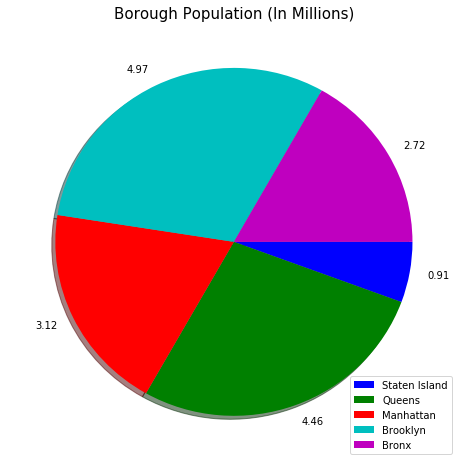

In [5]:
#Setting up population data to be readable
values = round(boroughpop["sum_population"]/1000000,2)
colors = ['b', 'g', 'r', 'c', 'm', 'y']
labels = boroughpop['borough']

#plotting population in pie chart
fig, ax = plt.subplots(figsize=(8, 8))
plt.pie(values, colors=colors, labels= values,counterclock=False, shadow=True)
plt.title('Borough Population (In Millions)',fontsize=15)
plt.legend(labels,loc=4)
plt.show()



### 2.3 Data Cleaning
Below I drop the uneeded columns. I also rename the columns we will be using to make them easy to work with. I also filter out any data that doesn't fall within March 21, 2016 and March 21, 2018.

In [6]:
#Dropping unneeded columns
accidents.dtypes
accidents.drop(accidents.columns[[3,4,5,6,9,17,18,19,20,22,25,26,27,28]], axis=1, inplace=True)

#Renaming columns
accidents.columns = ['Borough', 'Contributing_Factor_1', 'Contributing_Factor_2','Date','Latitude','Longitude','Cyclists Injured','Cyclists_Killed','Motorists Injured','Motorists_Killed','Pedestrians Injured','Pedestrians_Killed','Time','Vehicle Type 1','Vehicle Type 2']

#Cutting to have exactly two year's worth of data
accidents = accidents[(accidents['Date']>datetime.date(2016,3,21)) & (accidents['Date']<datetime.date(2018,3,21))]  

Here I extract valuable Month and Hour information from the Date and Time columns, respectively. I also opt to add a column for "Total Killed" and "Total Injured". There seems to already be a column for this, but I prefer to do this sumation within Python. I need months as numbers and as texts for sorting and display purposes, respectively.

In [7]:
#obtaining total injured, total killed, and month + hour of accident

accidents['Total Injured'] = accidents['Cyclists Injured'] + accidents['Motorists Injured'] + accidents['Pedestrians Injured']
accidents['Total Killed'] = accidents['Cyclists_Killed'] + accidents['Motorists_Killed'] + accidents['Pedestrians_Killed']
accidents['MonthNumber'] = pd.DatetimeIndex(accidents['Date']).month
accidents["Time"] = pd.to_datetime(accidents["Time"])
accidents["Hour"] = accidents["Time"].dt.hour

#Converting Month to text
accidents['Month'] = accidents['MonthNumber'].map({1:'January',2:'February',3:'March',4:'April',5:'May',6:'June',7:'July',8:'August',9:'September',10:'October',11:'November',12:'December'})


print(accidents)

              Borough                 Contributing_Factor_1  \
0            BROOKLYN                           Unspecified   
1                 NaN                     Oversized Vehicle   
2                 NaN                           Fell Asleep   
3                 NaN                          Unsafe Speed   
4            BROOKLYN                           Unspecified   
5                 NaN                       Other Vehicular   
6              QUEENS        Driver Inattention/Distraction   
7                 NaN                           Unspecified   
8                 NaN        Driver Inattention/Distraction   
9           MANHATTAN                    Turning Improperly   
10             QUEENS                   Alcohol Involvement   
11                NaN        Driver Inattention/Distraction   
12              BRONX        Driver Inattention/Distraction   
13                NaN        Passing or Lane Usage Improper   
14                NaN                 Following Too Clo

 ## 3. Visualizing the Data
 Now that the data is cleaned and organized, I begin my analysis.
 
 ### 3.1 Where Accidents Occur
 
 Accidents broken down by the five boroughs of New York City.
 
 ### 3.1.1 By Borough and Traveler (Absolute)

Injuries and deaths by borough and by type of traveler.

In [8]:
accidentsgrouped = accidents.groupby(['Borough']).sum()

#sorting accidents grouped by borough so that it matches up with our borough population dataframe. 
#This will be used later
accidentsgrouped['boroughsort']=accidentsgrouped.index
accidentsgrouped = accidentsgrouped.sort_values(by='boroughsort', ascending=False)

#Setting up per capita information now so as not to have duplicate code
accidentsgrouped['Pedestrians Injured Per Cap'] = np.divide(accidentsgrouped['Pedestrians Injured'],boroughpop['sum_population'])
accidentsgrouped['Motorists Injured Per Cap'] = np.divide(accidentsgrouped['Motorists Injured'],boroughpop['sum_population'])
accidentsgrouped['Cyclists Injured Per Cap'] = np.divide(accidentsgrouped['Cyclists Injured'],boroughpop['sum_population'])
accidentsgrouped['Pedestrians Killed Per Cap'] = np.divide(accidentsgrouped['Pedestrians_Killed'],boroughpop['sum_population'])
accidentsgrouped['Motorists Killed Per Cap'] = np.divide(accidentsgrouped['Motorists_Killed'],boroughpop['sum_population'])
accidentsgrouped['Cyclists Killed Per Cap'] = np.divide(accidentsgrouped['Cyclists_Killed'],boroughpop['sum_population'])

#Setting of dataframes around types of injuries and deaths. Separating each for clarity and sorting purposes
pedestinjuriesbyborough = accidentsgrouped.sort_values(by='Pedestrians Injured', ascending=False)
pedestdeathsbyborough = accidentsgrouped.sort_values(by='Pedestrians_Killed', ascending=False)
motorinjuriesbyborough = accidentsgrouped.sort_values(by='Motorists Injured', ascending=False)
motordeathsbyborough = accidentsgrouped.sort_values(by='Motorists_Killed', ascending=False)
cyclistinjuriesbyborough = accidentsgrouped.sort_values(by='Cyclists Injured', ascending=False)
cyclistdeathsbyborough = accidentsgrouped.sort_values(by='Cyclists_Killed', ascending=False)

print(accidentsgrouped)

                   Latitude     Longitude  Cyclists Injured  Cyclists_Killed  \
Borough                                                                        
STATEN ISLAND  2.821318e+05 -5.152194e+05                63                0   
QUEENS         1.800063e+06 -3.263856e+06               988                4   
MANHATTAN      1.437853e+06 -2.609254e+06              1416                8   
BROOKLYN       2.090392e+06 -3.802339e+06              1831               11   
BRONX          9.855489e+05 -1.782524e+06               479                2   

               Motorists Injured  Motorists_Killed  Pedestrians Injured  \
Borough                                                                   
STATEN ISLAND               1686                 8                  342   
QUEENS                     10741                18                 2881   
MANHATTAN                   3966                 3                 2564   
BROOKLYN                   11507                18              

Below we see a comparison between pedestrian, motorist, and cyclist injuries and deaths across buroughs. Interestingly, the ranking between boroughs changes across types of commuters and across injuries and deaths.

#### Observations
1. Why is Staten Island ranked third for motorist deaths, even though Staten Island is consistently ranked lowest in all other areas?
2. Why does Queens take the lead for pedestrians and motorists killed, even though it is ranked 2nd and 3rd in all other types of accidents?
3. Why does Manhattan seem to have the highest variability amongst buroughs, being last in Motorists killed, second to last in Motorists injured, 2nd in cyclists injured/killed and pedestrians killed, and middle of the pack for pedestrian injuries?
4. Why does Staten Island have such low rates of pedestrian and cyclist injuries and deaths?
5. Why does Brooklyn clearly have an injury problem, but less of a deaths problem?

#### Potential Additions

Of course, we would have to understand these numbers better in the context of per capita rates. This could be done by merging with a population dataset and dividing these rates by number of inhabitants. However, this would still not account for the fact that some areas have very high commuter rates.

Perhaps better would be to look at geographic size, or even total traffic flow. Geographic size may paint a better picture, but this still lacks information on density. In regards to total traffic flow, it would be fantastic if that dataset exists.

#### Takeaways

1. Do many vehicles pass through Staten Island, lending to its high motorist deaths? Or, does Staten Island have inadequate speed limits, traffic lights, stop signs, etc.? Higher speed tolerances may explain why Staten Island jumps more in deaths than in injuries. Perhaps Staten Island's motor policy needs review.
2. Does Queens have a higher proportion of people who walk? Or, are sidewalks inadequate, crosswalks ignored, and residents lacking general safety habits like looking both ways? In this area, perhaps Queen's outreach and development programs need review.
3. Does Manhattan see such high variability because it is the most diverse burough of them all? Or, does it clearly have a problem providing adequate laneways for cyclists? I know I personally see cyclists navigating erractically, crossing intersections when lights are red and even failing to look both ways when doing so. The data indicates a clear problem, supported by anecdotal evidence. Perhaps Manhattan needs to look into providing better bicycle lanes as well as fining cyclists for ignoring lights in the same way they would motorists.
4. Does Staten Island have few cyclists? Or does it adequately provide for them and enforce cyclist law? Perhaps Manhattan and Brooklyn could learn from them.
5. Is Brooklyn doing something right in the way it treats injuries and sets up its hospital systems?

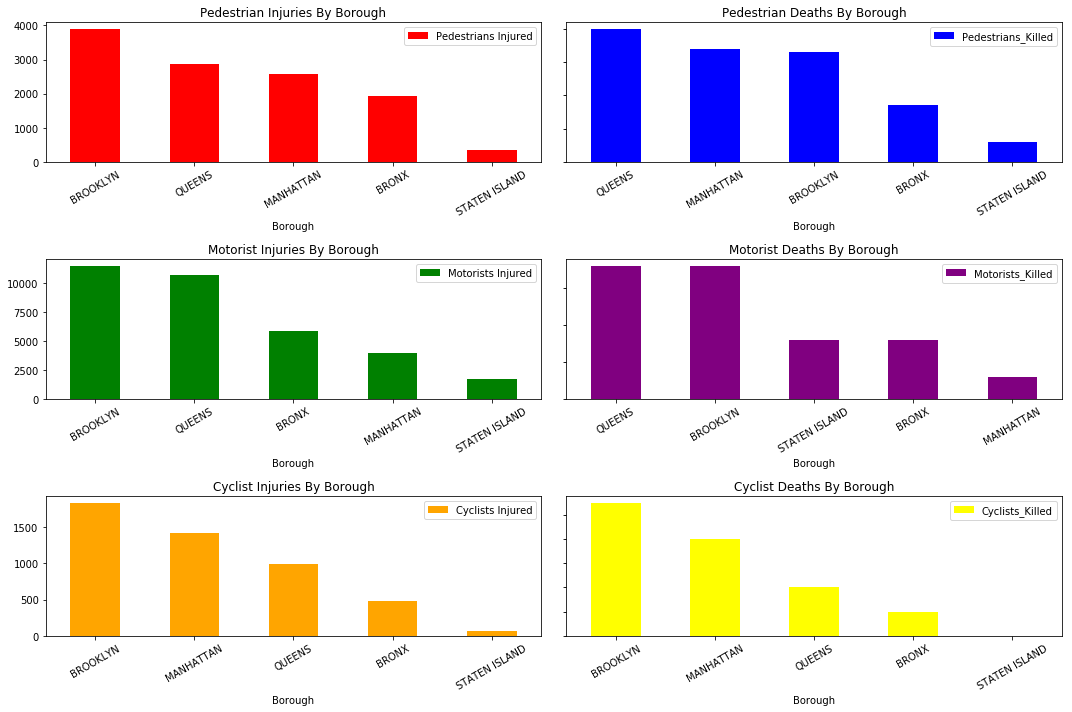

In [9]:
#setup the various bar charts

fig, ax = plt.subplots(nrows=3, ncols=2)
pedestinjuriesbyborough[['Pedestrians Injured']].plot(kind='bar', ax=ax[0,0], color=['red'], width=0.5, title ="Pedestrian Injuries By Borough", figsize=(15, 10), legend=True,fontsize=10, rot = 30)
pedestdeathsbyborough[['Pedestrians_Killed']].plot(kind='bar', ax=ax[0,1], color=['blue'],width=0.5, title ="Pedestrian Deaths By Borough", figsize=(15, 10), legend=True, fontsize=10,sharey=ax[0,0],rot = 30 )
motorinjuriesbyborough[['Motorists Injured']].plot(kind='bar', ax=ax[1,0], color=['green'], width=0.5, title ="Motorist Injuries By Borough", figsize=(15, 10), legend=True,fontsize=10, rot = 30)
motordeathsbyborough[['Motorists_Killed']].plot(kind='bar', ax=ax[1,1], color=['purple'],width=0.5, title ="Motorist Deaths By Borough", figsize=(15, 10), legend=True, fontsize=10,sharey=ax[1,0],rot = 30 )
cyclistinjuriesbyborough[['Cyclists Injured']].plot(kind='bar', ax=ax[2,0], color=['orange'],width=0.5, title ="Cyclist Injuries By Borough", figsize=(15, 10), legend=True, fontsize=10,rot = 30 )
cyclistdeathsbyborough[['Cyclists_Killed']].plot(kind='bar', ax=ax[2,1], color=['yellow'],width=0.5, title ="Cyclist Deaths By Borough", figsize=(15, 10), legend=True, fontsize=10,sharey=ax[2,0],rot = 30)

#ensuring format is as desired
fig.tight_layout()                                         
fig.subplots_adjust(wspace=0.05, hspace=0.7)
plt.show()

 ### 3.1.2 By Borough and Traveler (Per Capita)

Taking into account borough populations, some observations change or become clearer.

1. Staten Island has far more motorists killed per capita than other boroughs - something is clearly wrong.
2. Pedestrian deaths and injuries for Queens are somewhat explained by population size, though deaths are still on the high end. Manhattan and Queens have the most pedestrian deaths per capita by far.
3. Manhattan's variability now appears largely explained. It has by far the lowest motorist deaths and injuries per capita of any borough and yet it has the highest per capita rate of injuries and deaths of cyclists and pedestrians per capita than any other burough. This is likely explained by the foot traffic density and slow traffic speed in the city. It may also indicate inadequate protection for non-motorists.
4. The low level of cyclist injuries and deaths in Staten Island is even more impressive when looked at per capita.
5. The range of cyclist deaths and injuries between buroughs is much higher, which either indicates very different biking cultures or very different support systems for cyclists.


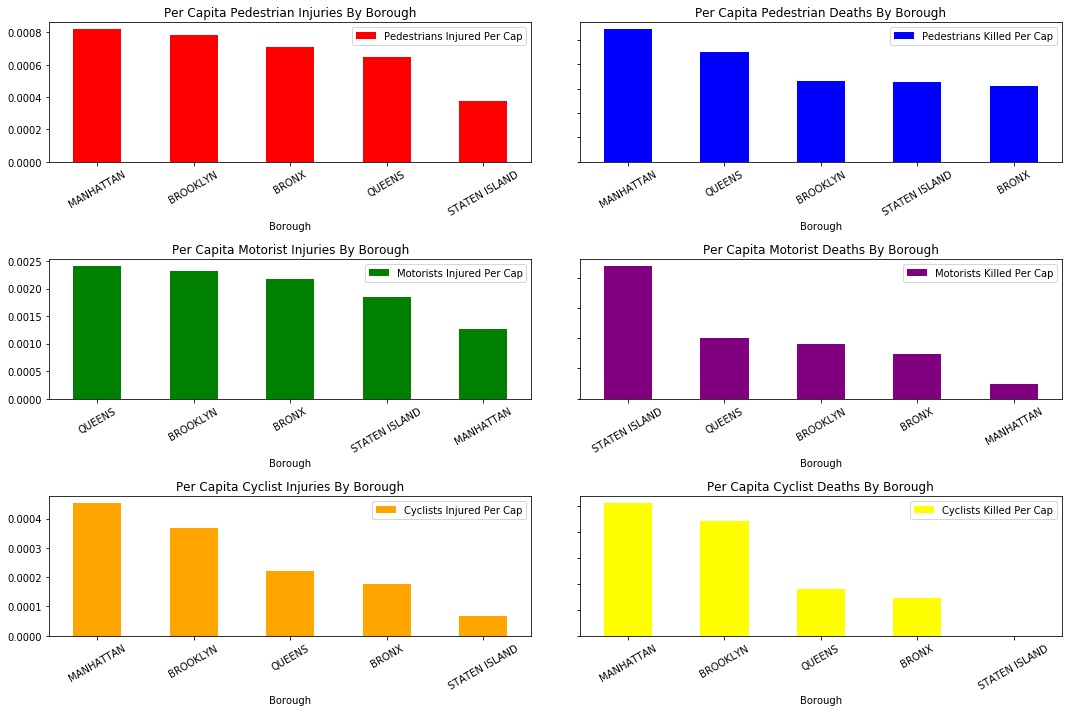

In [10]:
#setting up sorting for graphs
pedestinjuriesbyborough = accidentsgrouped.sort_values(by='Pedestrians Injured Per Cap', ascending=False)
pedestdeathsbyborough = accidentsgrouped.sort_values(by='Pedestrians Killed Per Cap', ascending=False)
motorinjuriesbyborough = accidentsgrouped.sort_values(by='Motorists Injured Per Cap', ascending=False)
motordeathsbyborough = accidentsgrouped.sort_values(by='Motorists Killed Per Cap', ascending=False)
cyclistinjuriesbyborough = accidentsgrouped.sort_values(by='Cyclists Injured Per Cap', ascending=False)
cyclistdeathsbyborough = accidentsgrouped.sort_values(by='Cyclists Killed Per Cap', ascending=False)

#plotting graphs together

fig, ax = plt.subplots(nrows=3, ncols=2)
pedestinjuriesbyborough[['Pedestrians Injured Per Cap']].plot(kind='bar', ax=ax[0,0], color=['red'], width=0.5, title ="Per Capita Pedestrian Injuries By Borough", figsize=(15, 10), legend=True,fontsize=10, rot = 30,sort_columns=True)
pedestdeathsbyborough[['Pedestrians Killed Per Cap']].plot(kind='bar', ax=ax[0,1], color=['blue'],width=0.5, title ="Per Capita Pedestrian Deaths By Borough", figsize=(15, 10), legend=True, fontsize=10,sharey=ax[0,0],rot = 30,sort_columns=True )
motorinjuriesbyborough[['Motorists Injured Per Cap']].plot(kind='bar', ax=ax[1,0], color=['green'], width=0.5, title ="Per Capita Motorist Injuries By Borough", figsize=(15, 10), legend=True,fontsize=10, rot = 30,sort_columns=True)
motordeathsbyborough[['Motorists Killed Per Cap']].plot(kind='bar', ax=ax[1,1], color=['purple'],width=0.5, title ="Per Capita Motorist Deaths By Borough", figsize=(15, 10), legend=True, fontsize=10,sharey=ax[1,0],rot = 30,sort_columns=True )
cyclistinjuriesbyborough[['Cyclists Injured Per Cap']].plot(kind='bar', ax=ax[2,0], color=['orange'],width=0.5, title ="Per Capita Cyclist Injuries By Borough", figsize=(15, 10), legend=True, fontsize=10,rot = 30,sort_columns=True )
cyclistdeathsbyborough[['Cyclists Killed Per Cap']].plot(kind='bar', ax=ax[2,1], color=['yellow'],width=0.5, title ="Per Capita Cyclist Deaths By Borough", figsize=(15, 10), legend=True, fontsize=10,sharey=ax[2,0],rot = 30,sort_columns=True)

fig.tight_layout()                                         
fig.subplots_adjust(wspace=0.10, hspace=0.7)
plt.show()

 ### 3.1.3 Borough and Traveler Summarized (Absolute)
 
 #### Observations and Takeaways
Looking at the numbers from another angle, we see that Brooklyn has the most injuries, but Queens has the most deaths. Furthermore, we see that this difference is largely due to pedestrian deaths, and this is despite the fact that Queens has fewer pedestrian injuries than Brooklyn. Does Queens have a poor hospital system that is either not getting injured pedestrians to treatment quickly enough or is losing them in the hospital themselves? Ultimately, are there more deaths that could have been just injuries?
 
We also see that while Manhattan and The Bronx have about the same amount of injuries, Manhattan has almost twice as many deaths as The Bronx. Again, this difference seems to be due to pedestrian deaths. This might be because of high pedestrian density in Manhattan. However, it might also inform us that Amblance ride windows are too long or hospital ER treatment not adequate for pedestrian type injuries.

In summary, motorist injuries dictate the numbers for accident injuries while pedestrian deaths dictate the numbers for accident deaths.

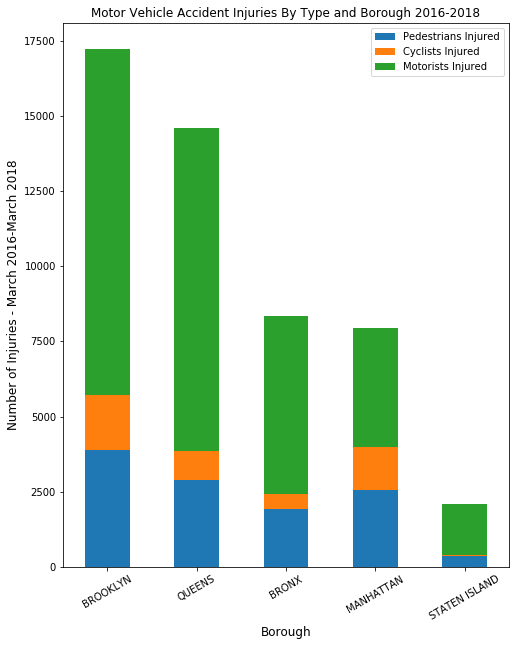

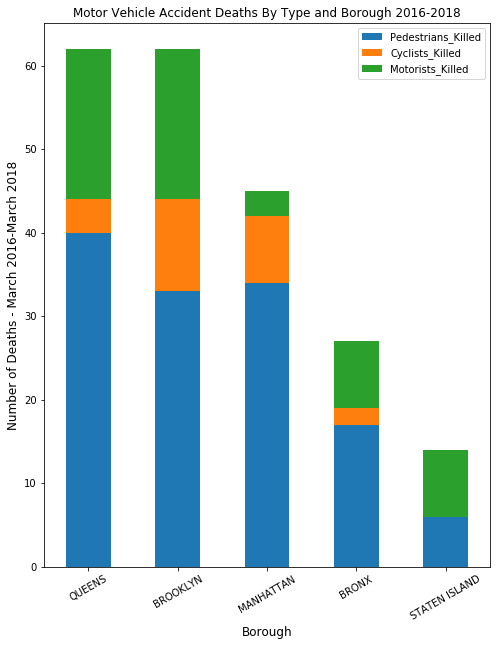

In [11]:
#Sort dataframes to allow for better chart viewing
injuriesbyborough = accidentsgrouped.sort_values(by='Total Injured', ascending=False)
deathsbyborough = accidentsgrouped.sort_values(by='Total Killed', ascending=False)

#Injuries by borough chart
ax = injuriesbyborough[['Pedestrians Injured','Cyclists Injured', 'Motorists Injured']].plot(kind='bar', stacked = True,title ="Motor Vehicle Accident Injuries By Type and Borough 2016-2018", figsize=(8, 10), legend=True, fontsize=10,rot=30)
ax.set_xlabel("Borough", fontsize=12)
ax.set_ylabel("Number of Injuries - March 2016-March 2018", fontsize=12)

#Deaths by borough chart
ax = deathsbyborough[['Pedestrians_Killed','Cyclists_Killed', 'Motorists_Killed']].plot(kind='bar', stacked = True,title ="Motor Vehicle Accident Deaths By Type and Borough 2016-2018", figsize=(8, 10), legend=True, fontsize=10,rot=30)
ax.set_xlabel("Borough", fontsize=12)
ax.set_ylabel("Number of Deaths - March 2016-March 2018", fontsize=12)

plt.show()

 ### 3.1.4 Borough and Traveler Summarized (Per Capita)
 
 Here we see just how dramatic the impact is of Staten Island's high motorist death rate. While is has fewer cyclist and pedestrian deaths than any other borough, it has significantly more motorist injuries per capita. This is why it is the deadliest burough.
 
 Looked at in this manner, some questions are raised as to Staten Island's ability to prevent accident deaths, either by preventing the kinds of accidents that cause deaths or by treating patient's appropriately so that they do not become fatalities.
 
 In regards to injuries per capita, no major new insights are revealed. Motorist injuries still drive the rankings, and there is no major difference in absolute ranking and per capita rankings. That being said, the differences between boroughs is more normalized in the per capita view.

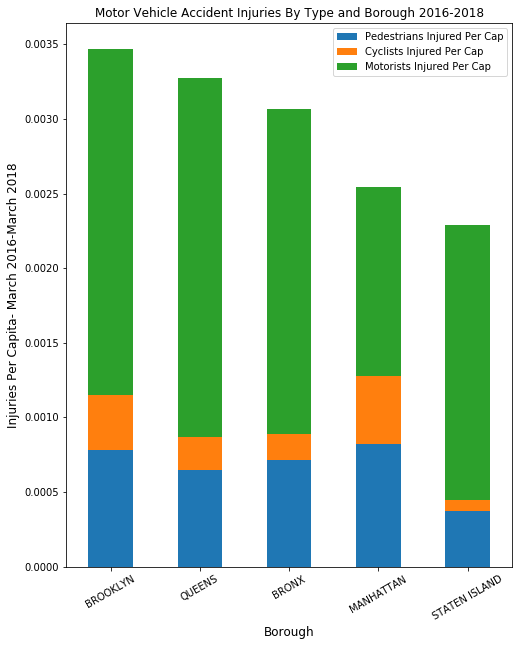

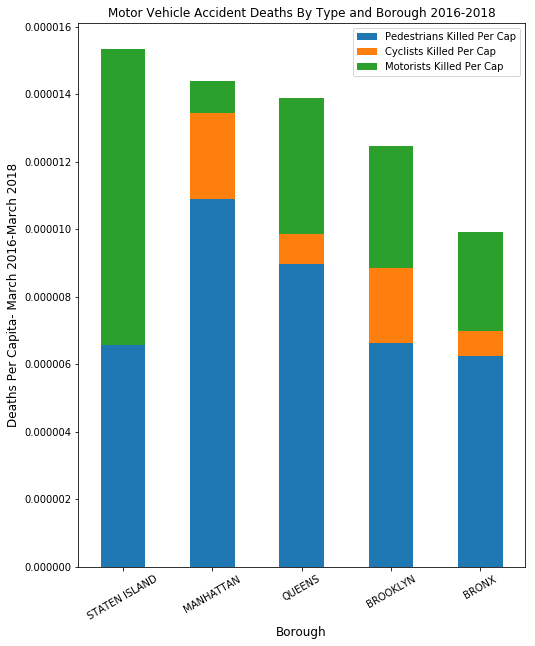

In [12]:
#Calculate total injuries and deaths per capita
injuriesbyborough['Total Injured Per Cap'] = np.divide(injuriesbyborough['Total Injured'],boroughpop['sum_population'])
deathsbyborough['Total Killed Per Cap'] = deathsbyborough['Pedestrians Killed Per Cap']+deathsbyborough['Motorists Killed Per Cap']+deathsbyborough['Cyclists Killed Per Cap']

#Use calculated values to sort charts
injuriesbyborough = injuriesbyborough.sort_values(by='Total Injured Per Cap', ascending=False)
deathsbyborough = deathsbyborough.sort_values(by='Total Killed Per Cap', ascending=False)

#Injuries per capita chart
ax = injuriesbyborough[['Pedestrians Injured Per Cap','Cyclists Injured Per Cap', 'Motorists Injured Per Cap']].plot(kind='bar', stacked = True,title ="Motor Vehicle Accident Injuries By Type and Borough 2016-2018", figsize=(8, 10), legend=True, fontsize=10,rot=30)
ax.set_xlabel("Borough", fontsize=12)
ax.set_ylabel("Injuries Per Capita- March 2016-March 2018", fontsize=12)

#Deaths per capita chart
ax = deathsbyborough[['Pedestrians Killed Per Cap','Cyclists Killed Per Cap', 'Motorists Killed Per Cap']].plot(kind='bar', stacked = True,title ="Motor Vehicle Accident Deaths By Type and Borough 2016-2018", figsize=(8, 10), legend=True, fontsize=10,rot=30)
ax.set_xlabel("Borough", fontsize=12)
ax.set_ylabel("Deaths Per Capita- March 2016-March 2018", fontsize=12)

plt.show()

Checking the largest accidents we must note that one accident in Manhattan caused 10 deaths, 8 of them pedestrians. This is the tragic NYC terrorist attack that occured last year. 

This is an outlier that should be considered, though even accounting for this, Manhattan still has a high rate of pedestrian deaths. I considered removing this outlier, but decided that 2 years is enough of a sample size to warrant inclusion.

In [13]:
#Get top 10 accidents by deaths
accidents = accidents.sort_values(by='Total Killed', ascending=False)
accidentstop10 =accidents.head(10)
print(accidentstop10)

          Borough                              Contributing_Factor_1  \
193647  MANHATTAN                                    Other Vehicular   
158551     QUEENS                                       Unsafe Speed   
230056        NaN                                        Unspecified   
392916        NaN                                        Unspecified   
402666   BROOKLYN                                        Unspecified   
296845   BROOKLYN                                            Illness   
20443         NaN                                        Unspecified   
1328          NaN                                       Unsafe Speed   
66575      QUEENS                                       Unsafe Speed   
227762   BROOKLYN  Pedestrian/Bicyclist/Other Pedestrian Error/Co...   

       Contributing_Factor_2       Date   Latitude  Longitude  \
193647           Unspecified 2017-10-31  40.729046  -74.01073   
158551           Unspecified 2017-09-18  40.762978  -73.83198   
230056      

 ## 3. Visualizing the Data
 ### 3.2 When Accidents Occur
 Not where, but when accidents occur. Based on time of day as well as month.

### 3.2.1 Time of Day
 
#### Observations and Takeaways
 
##### Injuries
 We see below that injuries for accidents are low in the wee hours of the night. They start rising at around 6 am, with a mini-peak at around 8 am. They fall until 10, at which point they steadily rise again before peaking at around 5pm.
 
 It seems that accidents are low from midnight to 6 am due to few drivers on the road. Accidents spike between 6-8 am as more drivers rush to work, perhaps falling afterwards as roads get too congested for real injuries to take place.
 
 As morning rushhour ends at 10am, the rise up to 5pm can be explained by crowded, but not completely congested streets.
 
Interestingly, accidents occur far more at the end of the day than at the beginning. One may posit that this is due to factors such as road-rage after a stressful day at work, fatigure after a long day, or eagerness to arrive home.

In reaction, officials may determine that targeted messaging to drivers may be a good way to alert them to the risks when driving home in the evening. They may also opt to post more traffic cops and officers throughout the city during these times.

##### Deaths

Perhaps unsurprisingly, deaths spike between 1am and 6am. This is presumably due to fatigue, drunk driving,the ability to drive quickly due to low congestion, and other factors that generally make driving at night so dangerous. Deaths from accidents are also consistently high between 3pm and 8pm, presumably due to evening rush hour chaos. Before 8pm, roads may not be too congested to prevent high speeds. Drivers are irritated, tired, and axious to get home. All of these likely lead to drivers pushing their limits.

Road reminders, announcements, and general education programs could reduce many of these spikes. Regardless, resources can be allocated more readily during these times.

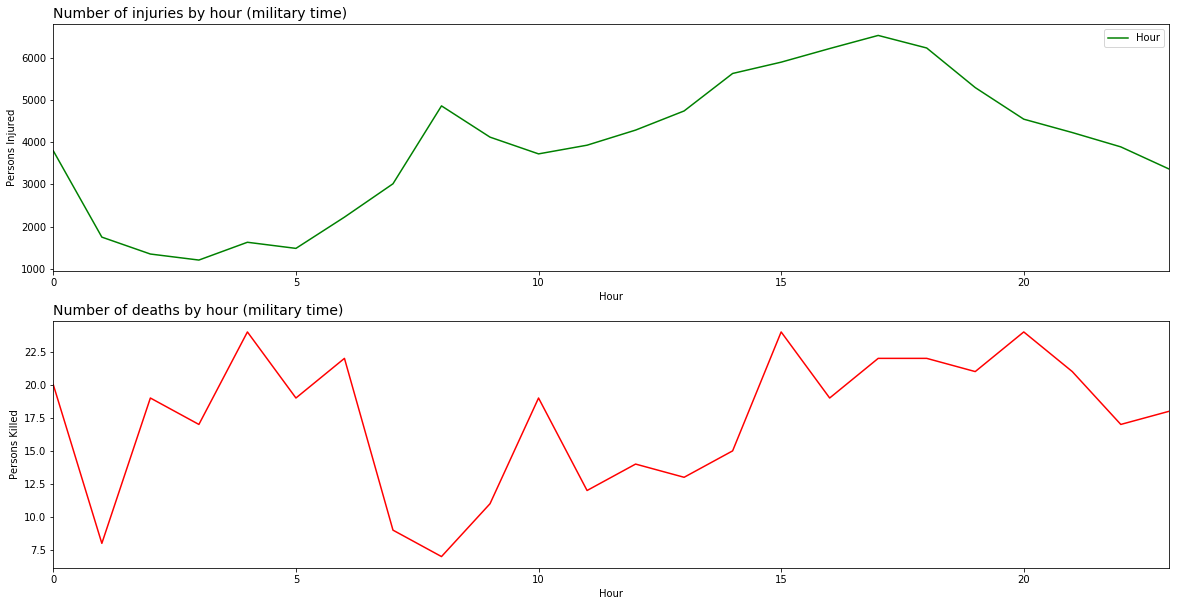

In [14]:
#setup accidents by hour dataframe
accidentsbyhour = accidents.groupby(['Hour']).sum()

#Plot injuries graph
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))  
accidentsbyhour['Total Injured'].plot(ax=ax[0], color='green')
ax[0].set_title('Number of injuries by hour (military time)', fontsize=14, loc='left')
ax[0].set_ylabel('Persons Injured')
ax[0].legend(['Hour', 'Persons Injured'])  

# Plot deaths graph
accidentsbyhour['Total Killed'].plot(ax=ax[1], color='red')
ax[1].set_title('Number of deaths by hour (military time)', fontsize=14, loc='left')
ax[1].set_ylabel('Persons Killed')
plt.show()

### 3.2.2 Month 
 
#### Observations and Takeaways
Injuries and deaths seems to show a similar seasonal trend, deaths spike earlier and more dramatically than injuries.

Deaths are at their highest from June to November while Injuries are at their highest August through October and January and February.

This may be weather related. More deaths may occur during the warm months as people are out and about in greater frequency. This makes a lot of sense when combined with the knowledge that the greatest proportion of deaths are from pedestrians and cyclists; in winter it is far to cold for pedestrians and cyclists to be out in large numbers.

Injury numbers are a little harder to explain. January and February are certainly months with adverse conditions, which might explain the high rates of injuries. August through October is holiday season, with many tourists entering NYC and many New Yorkers taking weekend trips. This may explain the injury spike from August through October.

City officials could be put on "high alert," or government services increased during peak months, and be trained to be more aware of certain types of accidents and injuries depending on what month/season they are in. 

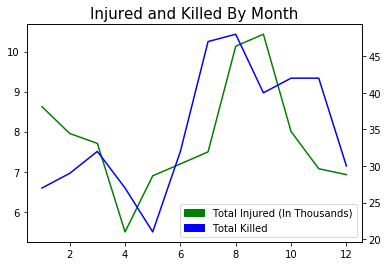

In [15]:
#Get dataframe for months grouping - order is 1-12 by month
injuriesbymonth = accidents.groupby(['MonthNumber']).sum()
injuriesbymonth['Month'] = ['January','February','March','April','May','June','July','August','September','October','November','December']

#Setup chart data
fig, ax1 = plt.subplots()
x = injuriesbymonth.index
y1 = injuriesbymonth['Total Injured']/1000
y2 = injuriesbymonth['Total Killed']
ax1.set_title("Injured and Killed By Month",fontsize=15)

#Chart dual line plot
ax2 = ax1.twinx()
ax1.plot(x, y1, 'g-', label = "Total Injured")
ax2.plot(x, y2, 'b-', label = "Total Killed")

#Setup legend
injured = mpatches.Patch(color='Green', label='Total Injured (In Thousands)')
killed = mpatches.Patch(color='Blue', label='Total Killed')
plt.legend(handles=[injured,killed])

plt.show()



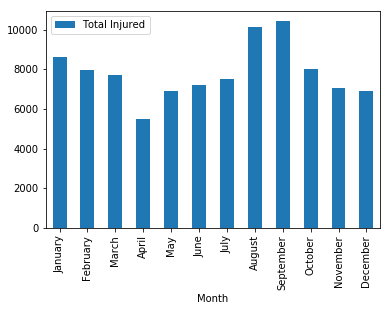

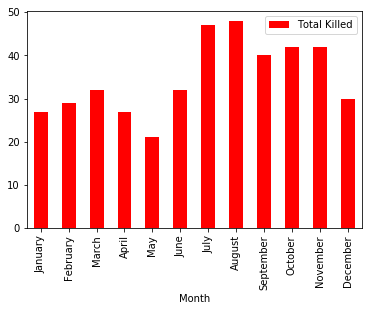

In [16]:
#Setup data for injuries and plot
injuriesbymonthplot = injuriesbymonth.set_index('Month')
injuriesbymonthplot.plot(y='Total Injured',kind='bar')

#Setup data for deaths and plot
deathsbymonth = accidents.groupby(['MonthNumber']).sum()
#Setting month for better visualization
deathsbymonth['Month'] = ['January','February','March','April','May','June','July','August','September','October','November','December']
deathsbymonthplot = deathsbymonth.set_index('Month')
deathsbymonthplot.plot(y='Total Killed',kind='bar', color='red')
plt.show()

### 3.2.3 Month and Traveler Type

Falls and rises in **injuries** are driven primarily by changes in motorist injuries. This does not come as a huge surprise, given that they account for the vast majority of injuries. 

However, the delta in **deaths** between months is caused by motorist, pedestrian, and cyclist deaths alike. Tragically, more than half of deaths are not motorist deaths, but pedestrian and cyclist deaths. This demonstrates the importance of protecting those on foot and bike with sidewalks, crosswalks, walking/biking lanes, etc; Motorists are protected de-facto by their cars, while those outside are extremely vulnerable.

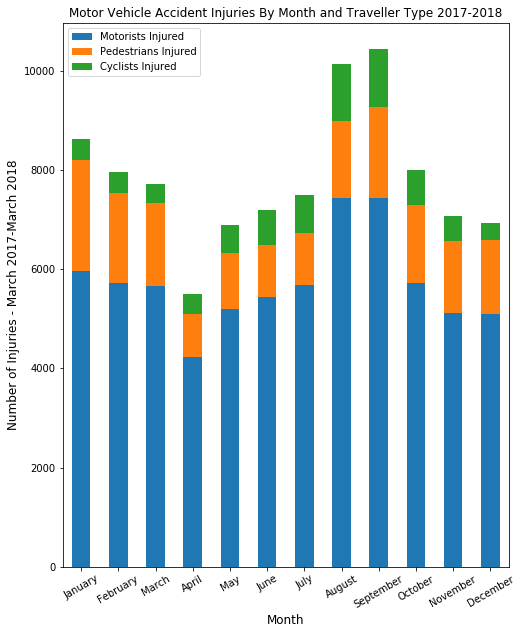

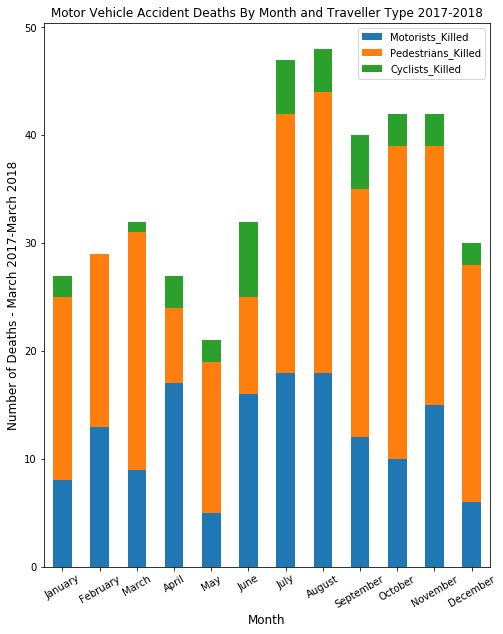

In [17]:
#Stacked bar chart for injuries by month and traveller type
ax = injuriesbymonthplot[['Motorists Injured','Pedestrians Injured','Cyclists Injured',]].plot(kind='bar', stacked = True,title ="Motor Vehicle Accident Injuries By Month and Traveller Type 2017-2018", figsize=(8, 10), legend=True, fontsize=10,rot=30)
ax.set_xlabel("Month", fontsize=12)
ax.set_ylabel("Number of Injuries - March 2017-March 2018", fontsize=12)

#Stacked bar chart for deaths by month and traveller type
ax = deathsbymonthplot[['Motorists_Killed','Pedestrians_Killed','Cyclists_Killed']].plot(kind='bar', stacked = True,title ="Motor Vehicle Accident Deaths By Month and Traveller Type 2017-2018", figsize=(8, 10), legend=True, fontsize=10,rot=30)
ax.set_xlabel("Month", fontsize=12)
ax.set_ylabel("Number of Deaths - March 2017-March 2018", fontsize=12)

plt.show()

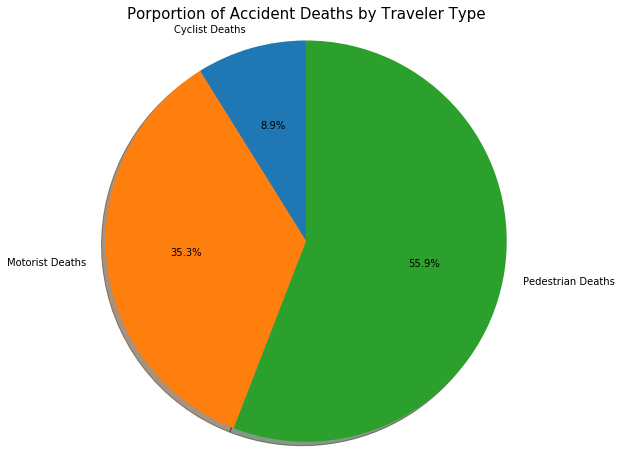

In [18]:
# Get totals for cyclist, motorist, and pedestrian deaths

cyclists_killed = pd.Series(accidents.Cyclists_Killed).sum()    
motorists_killed = pd.Series(accidents.Motorists_Killed).sum()   
pedestrians_killed = pd.Series(accidents.Pedestrians_Killed).sum()   

#Plot deaths by traveler type pie chart
labels = ["Cyclist Deaths", "Motorist Deaths", "Pedestrian Deaths"]
sizes = [cyclists_killed,motorists_killed,pedestrians_killed]
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax.set_title("Porportion of Accident Deaths by Traveler Type",fontsize=15)
plt.show()

### 3.2.4 Month and Borough

Data seems to suggest that changes in injury rates by month do not favor particular boroughs. While we observed earlier that boroughs are responsible for differering absolute amounts of accidents, their relative importance does not shift noticeably from month to month. In other words, injuries rise and fall in unison across boroughs throughout the year.

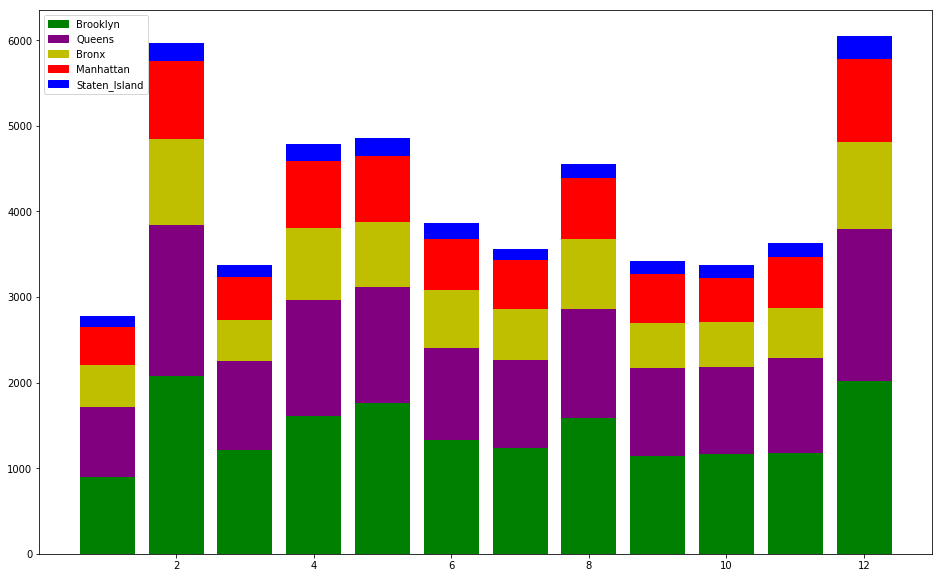

In [19]:
#double grouping in order to stack chart
accidentsbymonthborough = accidents.groupby(['Month', 'Borough'], as_index=False).sum()

#preparing accident data. Each section must be added in order to appear above the other
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 10))  
A1 = accidentsbymonthborough.query("Borough=='BROOKLYN'")['Total Injured']
B2 = np.add(A1,accidentsbymonthborough.query("Borough=='QUEENS'")['Total Injured'])
C3= np.add(B2,accidentsbymonthborough.query("Borough=='BRONX'")['Total Injured'])
D4 = np.add(C3,accidentsbymonthborough.query("Borough=='MANHATTAN'")['Total Injured'])
E5 = np.add(D4,accidentsbymonthborough.query("Borough=='STATEN ISLAND'")['Total Injured'])

#setting each bar againt the appropriate month
X = injuriesbymonth.index.tolist()

plt.bar(X, E5, color = 'b')
plt.bar(X, D4, color = 'r')
plt.bar(X, C3, color = 'y')
plt.bar(X, B2, color = 'purple')
plt.bar(X, A1, color = 'g')

#creating reference table
Brooklyn = mpatches.Patch(color='g', label='Brooklyn')
Queens = mpatches.Patch(color='Purple', label='Queens')
Bronx = mpatches.Patch(color='y', label='Bronx')
Manhattan = mpatches.Patch(color='r', label='Manhattan')
Staten_Island= mpatches.Patch(color='b', label='Staten_Island')
plt.legend(handles=[Brooklyn,Queens,Bronx,Manhattan,Staten_Island])


plt.show()

 ## 3. Visualizing the Data
 ### 3.3 Why Accidents Occur
Not where or when, but why accidents occur. The causes of accidents based on the primary car/driver at fault.

#### Observations and Takeaways

In the charts below I look at the top eight contributing factors to injuries and fatalities. The percentages relate to the percent that each item accounts for in the group of eight.

The biggest culprit by far for injuries is driver inattention. This is followed by a failure to yield right-of-way and following too closely. 

Perhaps unsurprisingly, the main causes of accident deaths are different. While the leading factor is still driver inattention, the 2nd and 3rd major contributing factors are failure to yield right of way and unsafe speeds. 

Surprisingly, alcohol consumption accounts for a relatively low percentage of injuries and deaths.

Officials looking to address injuries and/or fatalities can look to these results for direction in which practices to pursue and which behaviours to change.

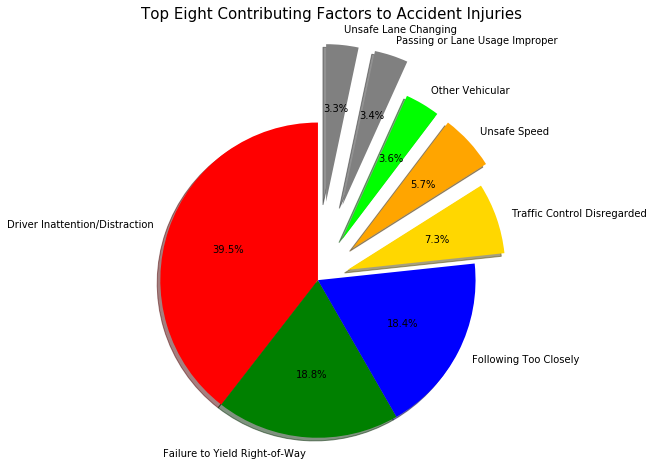

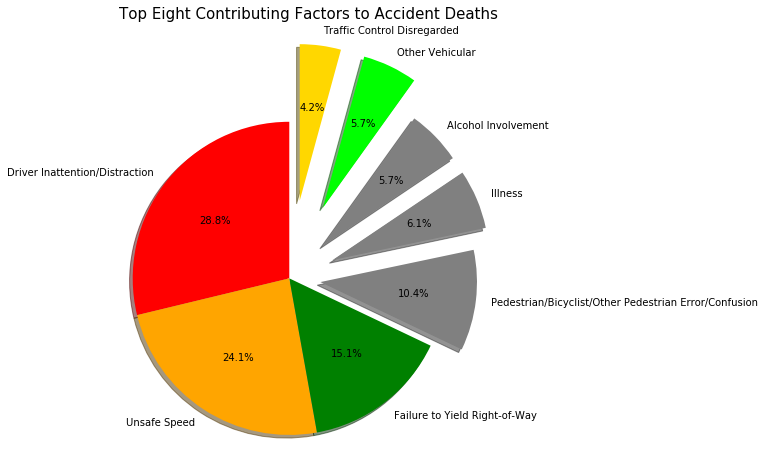

In [20]:
#remove unspecified as an option
accidents = accidents[accidents.Contributing_Factor_1 != 'Unspecified']

contributingfactor = accidents.groupby(['Contributing_Factor_1']).sum() #group dataset by contributing factor

contributingfactorinjured = contributingfactor.sort_values(by='Total Injured', ascending=False) #get top 8 injuries
contributingfactorinjured =contributingfactorinjured.head(8)

contributingfactorkilled = contributingfactor.sort_values(by='Total Killed', ascending=False) #get top 8 deaths
contributingfactorkilled =contributingfactorkilled.head(8)

#Plot injured pie chart
labels = contributingfactorinjured.index 
sizes =contributingfactorinjured["Total Injured"] 
explode = (0,0,0,.2,.3,.3,.5,.5) 
fig, ax = plt.subplots(figsize=(8, 8)) 
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
#Set colors to match death cause. Grey used for non-repeating causes.
colors = ['red','green','b','gold', "orange", "lime", "grey","grey"],
shadow=True, startangle=90) 
ax.axis('equal')  
# Equal aspect ratio ensures that pie is drawn as a circle. 
ax.set_title("Top Eight Contributing Factors to Accident Injuries",fontsize=15) 

#Plot deaths pie chart 
labels = contributingfactorkilled.index 
sizes =contributingfactorkilled["Total Killed"] 
explode = (0,0,0,.2,.3,.3,.5,.5) 
fig, ax = plt.subplots(figsize=(8, 8)) 
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
#Set colors to match injury cause. Grey used for non-repeating causes.
colors = ['red',"orange",'green','grey','grey',"grey","lime","gold"],
shadow=True, startangle=90) 
ax.axis('equal') 
# Equal aspect ratio ensures that pie is drawn as a circle. 
ax.set_title("Top Eight Contributing Factors to Accident Deaths",fontsize=15) 

plt.show()

 ## 4. Conclusion
 
 ### Key Observations
 
 Key accident observations for the city of New York include:
 
 #### Where
 1. Staten Island has a significantly higher per capita death rate of motorists than other boroughs.
 2. Manhattan is the most dangerous place for cyclists and pedestrians, but the safest place for motorists.
 3. Brooklyn has the most injuries due to accidents per capita while Staten Island has the least.
 4. However, Staten Island has the most deaths due to accidents per capita while the Bronx has by far the least.
 
 
 
#### When
 1. Accidents occur the most during both morning and evening rush hour.
 2. Deaths from accidents occur the most between 1 and 6am, and 3 and 8om.
 3. The late winter, early spring periods see the fewest injuries and deaths from accidents.
 4. July through September is the most dangerous time to be on the road, in terms of the risk of injury and death
 5. Deaths from accidents are at their highest between June and November.
 6. Injuries from accidents are at their highest August through October as well as in January and February.
 
#### How/Why
 
 1. While the vast majority of injuries are to the motorists themselves, more than half of accidents deaths are born by pedestrians and cyclists.
 2. The top cause of both injuries and deaths in accidents is Driver Inattention/Distraction
 3. The top three causes of death in accidents are distracted drivers, unsafe speeds, and a failure to yield the right-of-way. These causes account for a full two-thirds of all deaths in accidents. 
 
 
 ### Next Steps
  If NYC government officials are not already leveraging accident data to target efforts, there are many areas in which this data can guide their efforts. New Yorkers and travelers to NYC can also stand to gain from greater knowledge of when and where to be most aware in NYC. Some examples of actions that can be taken with these insights are:

1. Introducing stricter speed limits in Staten Island
2. A review of Manhattan's pedestrian and cyclist laws and infrastructure.
3. A review Brooklyn's hospital and emergency response systems to inform changes in other counties, particularly looking to improve pedestrian death rates in Manhattan and Brooklyn.
4. Implementing training programs and materials to inform drivers of major causes of injuries and deaths. 
5. Implementing signage that triggers at peak injury and death times warning drivers to pay extra attention.
6. If it can be shown that tourists are a major reason for the increase in accidents, then signage in airports, train stations, and major roads into NYC informing tourists to pay special attention to traffic around them.
7. Adjusting allocation of traffic officers and emergency reponse units to be higher from June to November, and lower in other months.
8. Alerting emergency response units to be on high alert during peak injury and death hours.
9. In an effort to influence driver behavior, promoting awareness around the fact that drivers cause more damage to others than to themselves.



Some observations in this dataset may also be applicable across other cities and countries, as it is reasonable to suggest that many trends around time and cause of accident are ubiquitous.
  
 ### Additional Research
It would be interesting to look at the causes of accidents both by month and by time of day. This could lead to insights as to why injuries and deaths are peaking during certain months and at certain times. This could further allow for targeted efforts to reduce these rates.

It would also be interesting to look at a metric for commuter density in each borough. On possible metric would be total driver time (average time spent in x borough multiplied by the number of daily drivers). If this metric could be calculated, one could get an even more detailed view of improvement areas by borough. I would posit that Manhattan's numbers would be less dramatic, given that traffic is so consistently dense.

Additionally, superimposing accident data over a map of NYC using the longitude and latitude information embedded in the dataset could help city planners make changes to allow for better flow of traffic, better placement of hospitals, better allocation of traffic and accident resources, etc.

Finally, pulling accidents data for 10, or even 20 years could provide some interesting insights. In particular, how have the causes of accidents changed and how have borough injury and death rates changed over the years. Investigation into these numbers could provide valuable insights that would both help tackle rising causes of injuries and deths from accidents. I would be interesting to look at the correlation between cell phone penetration and driver distraction rates to see if these might be related.


